In [144]:
## Import the packages needed

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
import statsmodels.graphics
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit

In [145]:
## Load UCI dataset

df = pd.read_csv('heart.csv')

In [146]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


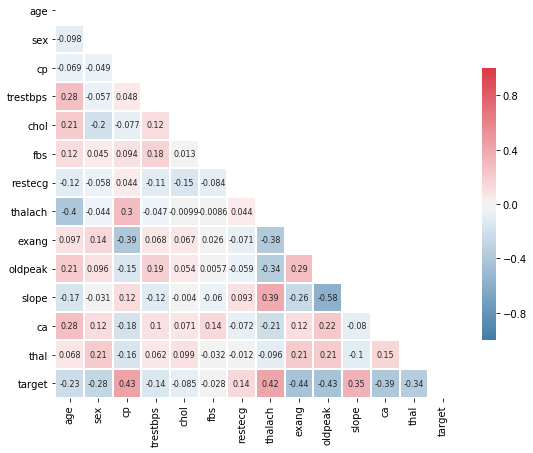

In [149]:
### Creating a correlation matrix to see if there are any
### variables that are highly correlated with each other.

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot = True,
           annot_kws = {'fontsize':8})

ax.set_ylim(14)

plt.savefig("heart_heatmap.png", bbox_inches='tight')

## Fitting a logistic regression

Below is very similar to what is in the other file. The point is to produce a logistic regression model that can be compared to the Bayesian approach.

In [84]:
### Setting the predictors

predictors = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal']

In [85]:
### Fitting the logistic regression

m = Logit(df['target'], df[predictors])
m = m.fit()

Optimization terminated successfully.
         Current function value: 0.351932
         Iterations 7


In [86]:
### Summary of the results

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  303
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                           12
Date:                Sat, 30 Nov 2019   Pseudo R-squ.:                  0.4893
Time:                        13:10:17   Log-Likelihood:                -106.64
converged:                       True   LL-Null:                       -208.82
Covariance Type:            nonrobust   LLR p-value:                 4.088e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0128      0.019      0.670      0.503      -0.025       0.050
sex           -1.6381      0.452     -3.625      0.000      -2.524      -0.752
cp             0.8490      0.184      4.613      0.000       0.488       1.210
trestbps      -0.0153      0.010     -1.562      0.118      -0.035       0.004
chol          -0.0036      0.004     -0.960      0.337      -0.011       0.004
fbs           -0.0115      0.526     -0.022      0.983      -1.042       1.019
restecg        0.5432      0.342      1.589      0.112      -0.127       1.213
thalach        0.0319      0.008      3.779      0.000       0.015       0.048
exang         -0.8920      0.403     -2.215      0.027      -1.681      -0.103
oldpeak       -0.4988      0.209     -2.381      0.017      -0.909      -0.088
slope          0.6092      0.346      1.761      0.078      -0.069       1.287
ca            -0.7725      0.189     -4.080      0.000      -1.144      -0.401
thal          -0.8438      0.287     -2.937      0.003      -1.407      -0.281
==============================================================================
"""

In [105]:
### run the prediction and produce probability values

df['p'] = m.predict(df[predictors])

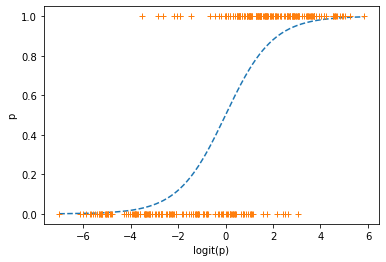

In [106]:
### Plot the logistic model

freq_model = df.sort_values(by = ['p'], axis = 0)
plt.plot(logit(freq_model['p']), freq_model['p'], '--')
plt.plot(logit(freq_model['p']), freq_model.target, '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.show()

In [108]:
### Creating error bars

freq_model['model_error'] = np.sqrt(1 - m.prsquared) * freq_model['p'].std()

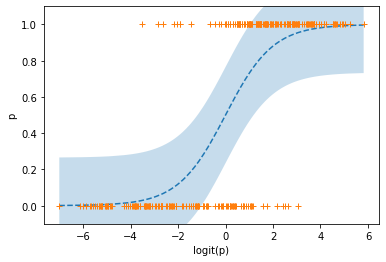

In [251]:
plt.plot(logit(freq_model['p']), freq_model['p'], '--')
plt.fill_between(logit(freq_model['p']), freq_model['p']-freq_model['model_error'], freq_model['p']+freq_model['model_error'], alpha = .25)
plt.plot(logit(freq_model['p']), freq_model.target, '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.ylim(-0.1, 1.1)
plt.show()

In [250]:
### Based on the other .py file, the best accuracy is produced when the
### threshold is .5

freq_model['y_hat'] = (freq_model['p'] > 0.5)*1

In [226]:
### Table of true positives and negatives, and false positives and negatives

pd.crosstab(freq_model['target'], freq_model['y_hat'])

y_hat,0,1
target,,
0,106,32
1,13,152


In [228]:
TP = pd.crosstab(freq_model['target'], freq_model['y_hat'])[1][1]
TN = pd.crosstab(freq_model['target'], freq_model['y_hat'])[0][0]
FN = pd.crosstab(freq_model['target'], freq_model['y_hat'])[0][1]
FP = pd.crosstab(freq_model['target'], freq_model['y_hat'])[1][0]

acc = (TP + TN) / (TP + TN + FN + FP)
print(acc)

0.8514851485148515


## Bayesian inference

The following fits a Bayesian model to create parameter estimates of the variables.

In [95]:
### Creating the model and computing 400,000 samples.

with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('target ~ age + sex + cp + trestbps + chol + fbs + restecg + thalach + exang + oldpeak + slope + ca + thal',
                            df,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(400000, step = pm.Metropolis(), tune=1000)
    burn_trace = trace[100000::5]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [thal]
>Metropolis: [ca]
>Metropolis: [slope]
>Metropolis: [oldpeak]
>Metropolis: [exang]
>Metropolis: [thalach]
>Metropolis: [restecg]
>Metropolis: [fbs]
>Metropolis: [chol]
>Metropolis: [trestbps]
>Metropolis: [cp]
>Metropolis: [sex]
>Metropolis: [age]
>Metropolis: [Intercept]
Sampling 2 chains: 100%|██████████| 802000/802000 [23:22<00:00, 571.81draws/s] 
The number of effective samples is smaller than 10% for some parameters.


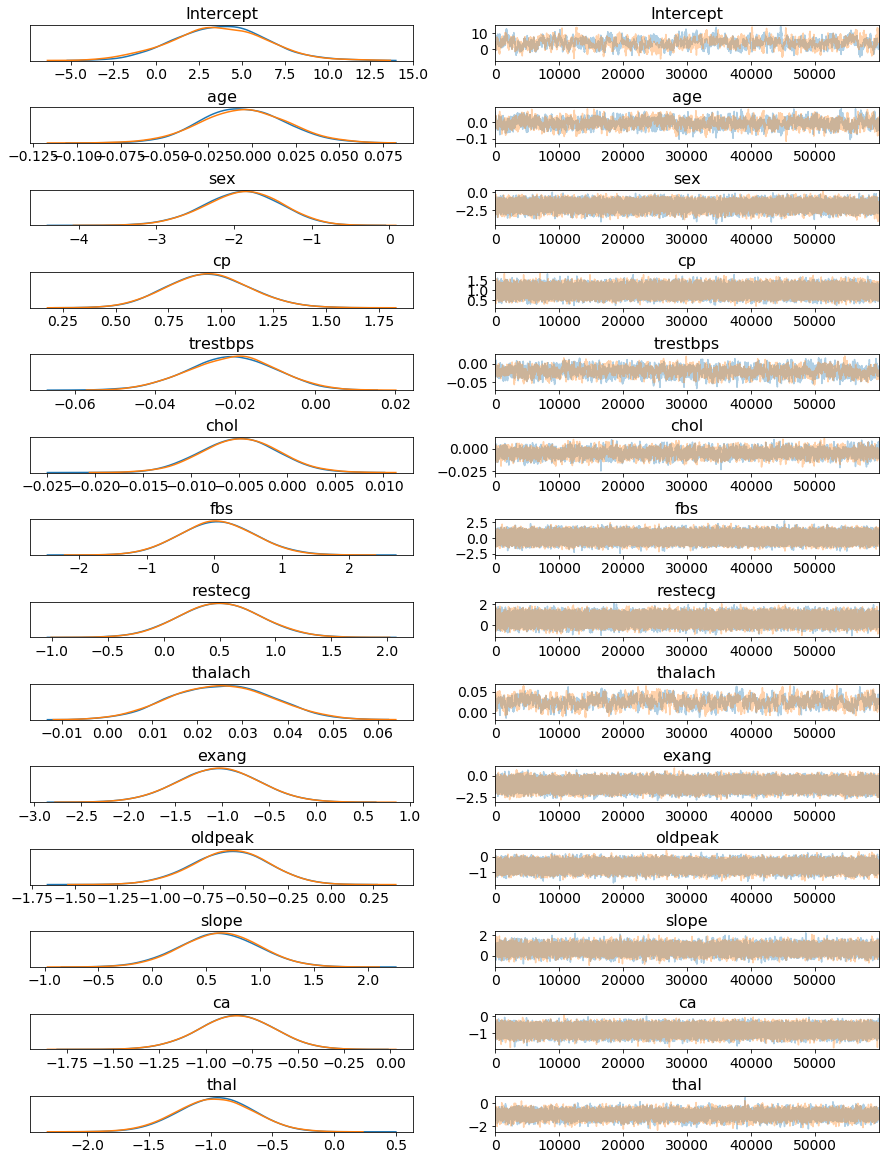

In [150]:
### Creating a trace plot to visualize the distributions.

pm.traceplot(burn_trace, figsize = (12,16));
plt.savefig("heart_traceplot.png", bbox_inches='tight')

In [114]:
### Summary table of the variables.

pm.summary(burn_trace)

/Users/jamesmcmahon/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,3.681341,2.714705,0.125025,-1.835432,8.837440,334.054384,1.000882
age,-0.005258,0.024576,0.000859,-0.052041,0.045006,644.773704,1.000130
sex,-1.902982,0.491676,0.006588,-2.880982,-0.960251,4285.735893,1.000575
cp,0.940150,0.195010,0.001521,0.562811,1.325013,18006.823241,0.999992
trestbps,-0.020914,0.010860,0.000346,-0.042317,-0.000074,904.618502,1.000673
chol,-0.005009,0.004004,0.000087,-0.012728,0.002969,1847.348408,1.000762
fbs,0.042890,0.548199,0.003128,-1.003537,1.147812,34380.101663,1.000115
restecg,0.499553,0.362265,0.002688,-0.197168,1.218545,16618.592159,1.000030
thalach,0.025187,0.011151,0.000467,0.003935,0.047077,462.072420,1.000020
exang,-1.048753,0.428312,0.004223,-1.889573,-0.207086,12493.594050,1.000007


In [115]:
### Fitting the probability curve with the model

y = pm.sample_posterior_predictive(burn_trace, model=logistic_model)

100%|██████████| 120000/120000 [02:03<00:00, 970.52it/s] 


In [120]:
### df['p2'] is the average of all of traces. 
### df['bayes_error'] uses all of the traces to calculate the standard deviation of the esitmates. 

df['p2'] = y['y'].mean(axis = 0)
df['bayes_error'] = y['y'].std(axis = 0)

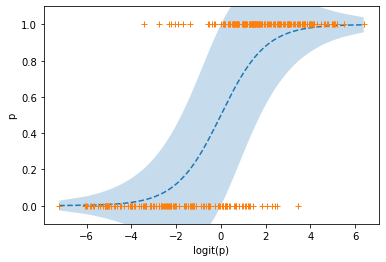

In [122]:
### Plotting the logistic regression from the Bayes estimates.

bayes_model = df.sort_values(by = ['p2'], axis = 0)
plt.plot(logit(bayes_model['p2']), bayes_model['p2'], '--')
plt.fill_between(logit(bayes_model['p2']), bayes_model['p2']-bayes_model['bayes_error'], bayes_model['p2']+bayes_model['bayes_error'], alpha = .25)
plt.plot(logit(bayes_model['p2']), bayes_model['target'], '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.ylim(-0.1, 1.1)
plt.show()

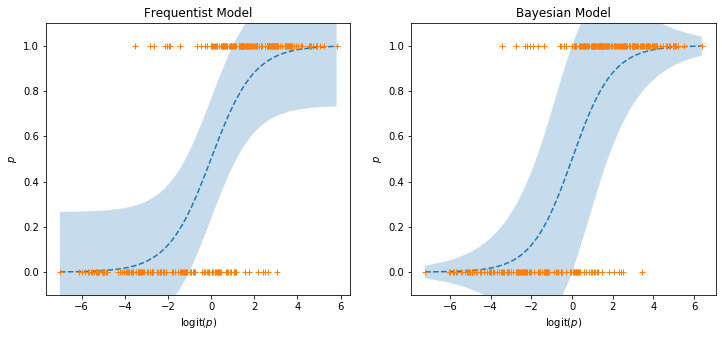

In [167]:
### comparing the approaches

fig, axes = plt.subplots(1, 2, sharey=False, figsize=(12, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.plot(logit(freq_model['p']), freq_model['p'], '--')
ax1.fill_between(logit(freq_model['p']), freq_model['p']-freq_model['model_error'], freq_model['p']+freq_model['model_error'], alpha = .25)
ax1.plot(logit(freq_model['p']), freq_model.target, '+')
ax1.set_ylim(-0.1,1.1)
ax1.set(xlabel='logit($p$)', 
       ylabel='$p$', title = "Frequentist Model")

ax2.plot(logit(bayes_model['p2']), bayes_model['p2'], '--')
ax2.fill_between(logit(bayes_model['p2']), bayes_model['p2']-bayes_model['bayes_error'], bayes_model['p2']+bayes_model['bayes_error'], alpha = .25)
ax2.plot(logit(bayes_model['p2']), bayes_model['target'], '+')
ax2.set_ylim(-0.1,1.1)
ax2.set(xlabel='logit($p$)', 
       ylabel='$p$', title = "Bayesian Model")

plt.savefig("heart_method_compare.png", bbox_inches='tight')

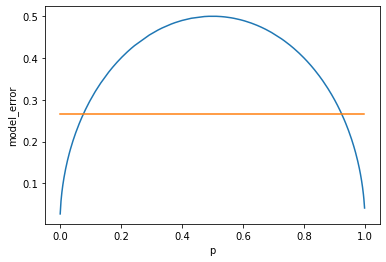

In [126]:
sns.lineplot(data = bayes_model, x = "p2", y = "bayes_error")
sns.lineplot(data = freq_model, x = "p", y = "model_error")

In [200]:
ths = np.arange(0.025, 1.0, 0.025)
accuracy = []

for th in ths:
    y_hat = (bayes_model['p2'] > th)*1
    
    TP = pd.crosstab(bayes_model['target'], y_hat)[1][1]
    TN = pd.crosstab(bayes_model['target'], y_hat)[0][0]
    FN = pd.crosstab(bayes_model['target'], y_hat)[0][1]
    FP = pd.crosstab(bayes_model['target'], y_hat)[1][0]
    
    acc = (TP + TN) / (TP + TN + FN + FP)
    accuracy.append(acc)

In [202]:
accuracy_df = pd.DataFrame()
accuracy_df["Threshold"] = ths
accuracy_df["Accuracy"] = accuracy

In [249]:
accuracy_df

,Threshold,Accuracy
0,0.025,0.669967
1,0.050,0.712871
2,0.075,0.742574
3,0.100,0.768977
4,0.125,0.782178
5,0.150,0.782178
6,0.175,0.792079
7,0.200,0.795380
8,0.225,0.808581
9,0.250,0.825083


In [231]:
accuracy_df.loc[accuracy_df['Accuracy'] == accuracy_df['Accuracy'].max()]

,Threshold,Accuracy
22,0.575,0.867987


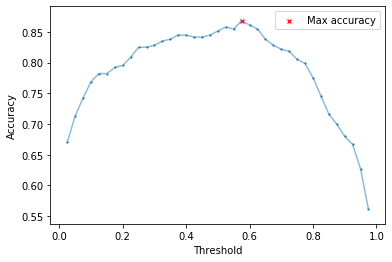

In [240]:
sns.scatterplot(data = accuracy_df, x = "Threshold", y = "Accuracy", marker = ".")
sns.scatterplot(data = accuracy_df.loc[accuracy_df['Accuracy'] == accuracy_df['Accuracy'].max()], 
                x = "Threshold", y = "Accuracy", marker = "X", color = "red", label = "Max accuracy")
sns.lineplot(data = accuracy_df, x = "Threshold", y = "Accuracy", alpha = .5)

plt.savefig("heart_bayes_accuracy.png", bbox_inches='tight')